In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
# The dimensions of our input image
img_width = 50
img_height = 50
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "block2_conv2"

# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.VGG16(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

# Compute image inputs that maximize per-filter activations
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10
    img = initialize_image()
    for iteration in range(iterations):
        loss, img_raw = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img_processed = deprocess_image(img_raw[0].numpy())
    return loss, img_raw, img_processed


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_imgs = np.load("/content/drive/MyDrive/cnn_embed/vgg_%s.npy" % (layer_name))

In [ ]:
# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 16
m = 8
cropped_width = img_width #- 25 * 2
cropped_height = img_height # - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = m * cropped_height + (m - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(m):
        img = all_imgs[i * m + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("/content/drive/MyDrive/cnn_embed/stiched_filters_vgg_%s.png" % (layer_name)", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#for i in range(128):
#    loss, img_raw, img_processed = visualize_filter(i)
#    keras.preprocessing.image.save_img("/content/drive/MyDrive/cnn_embed/vgg22figs/%d.png" %i, img_processed)

In [ ]:
!pip install pyssim

In [ ]:
import ssim.ssimlib as pyssim
import datetime
import os

In [ ]:
def get_image_similarity(img1, img2):
    similarity = pyssim.SSIM(img1).cw_ssim_value(img2)
    return similarity

def build_similarity_matrix(dir_name):
    images = [f for f in os.listdir(dir_name) if not f.startswith('.')]
    num_images = len(images)
    sm = np.zeros(shape=(num_images, num_images), dtype=np.float64)
    np.fill_diagonal(sm, 1.0)

    start_total = datetime.datetime.now()

    # Traversing the upper triangle only - transposed matrix will be used
    # later for filling the empty cells.
    k = 0
    for i in range(sm.shape[0]):
        for j in range(sm.shape[1]):
            j = j + k
            if i != j and j < sm.shape[1]:
                sm[i][j] = get_image_similarity('%s/%s' % (dir_name, images[i]),
                                                '%s/%s' % (dir_name, images[j]),
                                                )
        k += 1

    # Adding the transposed matrix and subtracting the diagonal to obtain
    # the symmetric similarity matrix
    sm = sm + sm.T - np.diag(sm.diagonal())

    end_total = datetime.datetime.now()
    print("Done - total calculation time: %d seconds" % (end_total - start_total).total_seconds())
    return sm

In [ ]:
DIR_NAME = '/content/drive/MyDrive/cnn_embed/vgg22figs'
similarity_matrix = build_similarity_matrix(DIR_NAME)

Done - total calculation time: 730 seconds


In [ ]:
np.save("/content/drive/MyDrive/cnn_embed/vgg_%s_similarity_matrix" % (layer_name), similarity_matrix)  

In [ ]:
n_neighbor = 5
n_image = len(similarity_matrix)
idx = [np.argsort(similarity_matrix[i])[-n_neighbor:][::-1] for i in range(n_image)]
distance = [similarity_matrix[i][idx[i]]for i in range(n_image)]

In [ ]:
similarity_matrix

array([[1.        , 0.41042019, 0.40153821, ..., 0.38874338, 0.4152082 ,
        0.4154384 ],
       [0.41042019, 1.        , 0.39649719, ..., 0.34366744, 0.40336293,
        0.40519465],
       [0.40153821, 0.39649719, 1.        , ..., 0.33510394, 0.39912735,
        0.39613938],
       ...,
       [0.38874338, 0.34366744, 0.33510394, ..., 1.        , 0.36213443,
        0.34545676],
       [0.4152082 , 0.40336293, 0.39912735, ..., 0.36213443, 1.        ,
        0.40451503],
       [0.4154384 , 0.40519465, 0.39613938, ..., 0.34545676, 0.40451503,
        1.        ]])

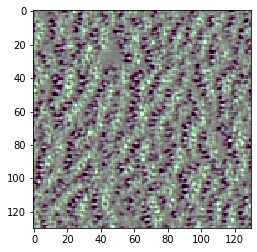

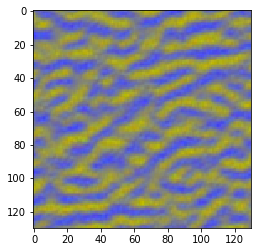

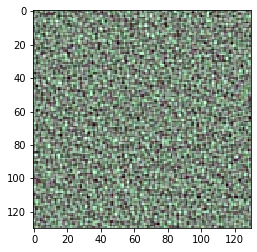

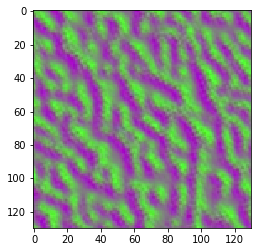

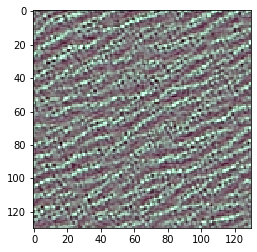

In [ ]:
for i in idx[39]:
  img = all_imgs[i]
  img = img.reshape(cropped_width,cropped_height,3)
  plt.imshow(img, interpolation='nearest')
  plt.show()